In [14]:
import cv2
import math
import matplotlib.pyplot as plt

import numpy as np
import torch
from torch import nn, optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.hub import load_state_dict_from_url

from torch.utils.data import Dataset
import os

from PIL import Image

from tqdm import tqdm

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns
from scipy.ndimage import gaussian_filter1d


In [13]:
torch.__version__

'1.12.0'

In [15]:
torch.backends.mps.is_available()

True

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device='mps'
print('Using device:', device)

Using device: mps


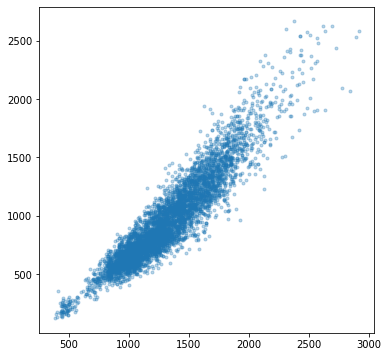

In [17]:
root="./chest_xray/chest_xray_ternary/train"
data=[]
for catagory in os.listdir(root):
        if catagory=='.DS_Store':
            continue
        catagory_path=os.path.join(root,catagory)
        for image in os.listdir(catagory_path):
            image_path=os.path.join(catagory_path,image)
            data.append((Image.open(image_path).width,Image.open(image_path).height))
x = np.array([i[0] for i in data])
y = np.array([i[1] for i in data])
plt.figure(figsize=(6,6))
plt.scatter(x, y, alpha=0.3,marker='.',)
plt.show()


In [18]:
class X_ray(Dataset):
    def __init__(self,root,transform):
        self.root=root
        self.transform = transform
        self.data=[]
        self.namelabel={"BACTERIAL":0,"NORMAL":1,"VIRAL":2}

        for catagory in os.listdir(root):
            if catagory=='.DS_Store':
                continue
            catagory_path=os.path.join(root,catagory)
            for image in os.listdir(catagory_path):
                image_path=os.path.join(catagory_path,image)
                self.data.append((image_path,catagory))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_loc = self.data[idx][0]
     
        # Use PIL for image loading
        image = Image.open(img_loc).convert("RGB")
        # Apply the transformations
        tensor_image = self.transform(image)

        target=torch.tensor(int(self.namelabel[self.data[idx][1]]))
        
        return tensor_image.to(device),target.to(device)

In [19]:
trnsfrm = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor()
])

train_vaild_set=X_ray(
    root='./chest_xray/chest_xray_ternary/train',
    transform=trnsfrm
)

train_num = int(len(train_vaild_set)*0.7)+1
valid_num = int(len(train_vaild_set)*0.3)


train_set,valid_set=torch.utils.data.random_split(
    train_vaild_set,
    lengths=[train_num,valid_num],
    generator=torch.Generator().manual_seed(0)
)


In [29]:
train_loader=torch.utils.data.DataLoader(
    train_set,
    batch_size=64,
    shuffle=True,
    num_workers=0
)
valid_loader=torch.utils.data.DataLoader(
    valid_set,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

In [36]:
model=models.vgg16(pretrained=False).to(device)
model.classifier._modules['6'] = nn.Linear(4096,3)

/Users/lihang/Library/Python/3.8/lib/python/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/lihang/Library/Python/3.8/lib/python/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [32]:
def valid(valid_loader,net):
    net=net.to(device)
    loss_fn = nn.CrossEntropyLoss()
    correct = 0
    total = 0
    total_valid_loss = 0
    n = 0    # counter for number of minibatches
    with torch.no_grad():           #valid
        for data in valid_loader:
            img,target = data
            outputs = net(img)
            loss = loss_fn(outputs,target)
            total_valid_loss += loss.item()
            n+=1

        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)    # add in the number of labels in this batch
        correct += (predicted == target).sum().item()  # add in the number of correct labels

        # collect together statistics for this epoch

        lvld = total_valid_loss/n
        avld = correct/total
    return lvld,avld

In [54]:
def Training(train_loader,valid_loader,net,nepochs):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    statsrec = np.zeros((4,nepochs))    
    net=net.to(device)
    for epoch in range(nepochs): 
        print("------------epoch:{d}------------".format(epoch+1)) 
        correct=0            # number of examples predicted correctly (for accuracy) 
        total = 0            # number of examples
        running_loss = 0.0   # accumulated loss (for mean loss)
        n = 0                # number of minibatches
        for data in tqdm(train_loader):
            inputs, labels = data

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward, backward, and update parameters
            outputs = net(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # accumulate data for accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels

            n += 1
            # if n%100 == 0:
            #     print('Numbers of training:{}, Loss:{:.3f}'.format(n,loss))

        ltrn = running_loss/n
        atrn = correct/total 

        lvld, avld=valid(valid_loader,net)

        statsrec[:,epoch] = (ltrn, atrn, lvld, avld)

        print('accurancy of train:{:.1%}, accurancy of validation:{:.1%}'.format(atrn,avld))

    return statsrec

    

In [55]:
nepochs=5
Training_statsrec=Training(train_loader,valid_loader,model,nepochs)

KeyError: 'd'

In [14]:
nepochs=50
Training_statsrec=Training(train_loader,valid_loader,model,nepochs)

############------Number of training epochs:1-------###########


100%|██████████| 58/58 [19:14<00:00, 19.91s/it]


accurancy of train:47.6%, accurancy of validation:45.5%
############------Number of training epochs:2-------###########


100%|██████████| 58/58 [19:25<00:00, 20.09s/it]


accurancy of train:49.3%, accurancy of validation:54.5%
############------Number of training epochs:3-------###########


100%|██████████| 58/58 [19:50<00:00, 20.52s/it]


accurancy of train:49.3%, accurancy of validation:39.4%
############------Number of training epochs:4-------###########


100%|██████████| 58/58 [20:08<00:00, 20.83s/it]


accurancy of train:49.7%, accurancy of validation:39.4%
############------Number of training epochs:5-------###########


100%|██████████| 58/58 [20:20<00:00, 21.04s/it]


accurancy of train:59.5%, accurancy of validation:69.7%
############------Number of training epochs:6-------###########


100%|██████████| 58/58 [20:10<00:00, 20.86s/it]


accurancy of train:65.8%, accurancy of validation:63.6%
############------Number of training epochs:7-------###########


100%|██████████| 58/58 [20:28<00:00, 21.18s/it]


accurancy of train:70.7%, accurancy of validation:69.7%
############------Number of training epochs:8-------###########


100%|██████████| 58/58 [20:07<00:00, 20.82s/it]


accurancy of train:72.8%, accurancy of validation:63.6%
############------Number of training epochs:9-------###########


100%|██████████| 58/58 [20:11<00:00, 20.89s/it]


accurancy of train:74.5%, accurancy of validation:69.7%
############------Number of training epochs:10-------###########


100%|██████████| 58/58 [20:31<00:00, 21.24s/it]


accurancy of train:75.2%, accurancy of validation:63.6%
############------Number of training epochs:11-------###########


100%|██████████| 58/58 [20:27<00:00, 21.17s/it]


accurancy of train:74.7%, accurancy of validation:81.8%
############------Number of training epochs:12-------###########


100%|██████████| 58/58 [20:24<00:00, 21.11s/it]


accurancy of train:76.8%, accurancy of validation:84.8%
############------Number of training epochs:13-------###########


100%|██████████| 58/58 [20:12<00:00, 20.90s/it]


accurancy of train:77.3%, accurancy of validation:72.7%
############------Number of training epochs:14-------###########


100%|██████████| 58/58 [20:12<00:00, 20.91s/it]


accurancy of train:76.9%, accurancy of validation:57.6%
############------Number of training epochs:15-------###########


100%|██████████| 58/58 [20:07<00:00, 20.82s/it]


accurancy of train:77.7%, accurancy of validation:78.8%
############------Number of training epochs:16-------###########


100%|██████████| 58/58 [20:11<00:00, 20.89s/it]


accurancy of train:78.1%, accurancy of validation:60.6%
############------Number of training epochs:17-------###########


100%|██████████| 58/58 [20:10<00:00, 20.87s/it]


accurancy of train:78.4%, accurancy of validation:75.8%
############------Number of training epochs:18-------###########


100%|██████████| 58/58 [20:09<00:00, 20.85s/it]


accurancy of train:79.1%, accurancy of validation:81.8%
############------Number of training epochs:19-------###########


100%|██████████| 58/58 [20:03<00:00, 20.76s/it]


accurancy of train:77.6%, accurancy of validation:63.6%
############------Number of training epochs:20-------###########


100%|██████████| 58/58 [20:06<00:00, 20.81s/it]


accurancy of train:79.1%, accurancy of validation:81.8%
############------Number of training epochs:21-------###########


100%|██████████| 58/58 [20:10<00:00, 20.87s/it]


accurancy of train:79.3%, accurancy of validation:66.7%
############------Number of training epochs:22-------###########


100%|██████████| 58/58 [20:13<00:00, 20.93s/it]


accurancy of train:79.7%, accurancy of validation:66.7%
############------Number of training epochs:23-------###########


100%|██████████| 58/58 [20:14<00:00, 20.94s/it]


accurancy of train:79.6%, accurancy of validation:84.8%
############------Number of training epochs:24-------###########


100%|██████████| 58/58 [20:11<00:00, 20.88s/it]


accurancy of train:80.1%, accurancy of validation:69.7%
############------Number of training epochs:25-------###########


100%|██████████| 58/58 [20:09<00:00, 20.85s/it]


accurancy of train:79.7%, accurancy of validation:75.8%
############------Number of training epochs:26-------###########


100%|██████████| 58/58 [20:09<00:00, 20.86s/it]


accurancy of train:79.7%, accurancy of validation:81.8%
############------Number of training epochs:27-------###########


100%|██████████| 58/58 [20:14<00:00, 20.94s/it]


accurancy of train:80.8%, accurancy of validation:81.8%
############------Number of training epochs:28-------###########


100%|██████████| 58/58 [20:10<00:00, 20.87s/it]


accurancy of train:80.0%, accurancy of validation:72.7%
############------Number of training epochs:29-------###########


100%|██████████| 58/58 [20:12<00:00, 20.91s/it]


accurancy of train:80.9%, accurancy of validation:36.4%
############------Number of training epochs:30-------###########


100%|██████████| 58/58 [20:10<00:00, 20.88s/it]


accurancy of train:81.4%, accurancy of validation:87.9%
############------Number of training epochs:31-------###########


100%|██████████| 58/58 [20:13<00:00, 20.92s/it]


accurancy of train:80.6%, accurancy of validation:84.8%
############------Number of training epochs:32-------###########


100%|██████████| 58/58 [20:33<00:00, 21.27s/it]


accurancy of train:82.2%, accurancy of validation:84.8%
############------Number of training epochs:33-------###########


100%|██████████| 58/58 [20:31<00:00, 21.23s/it]


accurancy of train:82.7%, accurancy of validation:84.8%
############------Number of training epochs:34-------###########


100%|██████████| 58/58 [20:23<00:00, 21.09s/it]


accurancy of train:82.9%, accurancy of validation:87.9%
############------Number of training epochs:35-------###########


100%|██████████| 58/58 [20:06<00:00, 20.80s/it]


accurancy of train:82.2%, accurancy of validation:69.7%
############------Number of training epochs:36-------###########


100%|██████████| 58/58 [20:04<00:00, 20.78s/it]


accurancy of train:82.5%, accurancy of validation:87.9%
############------Number of training epochs:37-------###########


100%|██████████| 58/58 [20:00<00:00, 20.70s/it]


accurancy of train:82.7%, accurancy of validation:78.8%
############------Number of training epochs:38-------###########


100%|██████████| 58/58 [20:12<00:00, 20.91s/it]


accurancy of train:83.1%, accurancy of validation:75.8%
############------Number of training epochs:39-------###########


100%|██████████| 58/58 [20:59<00:00, 21.71s/it]


accurancy of train:84.2%, accurancy of validation:78.8%
############------Number of training epochs:40-------###########


100%|██████████| 58/58 [20:58<00:00, 21.70s/it]


accurancy of train:84.3%, accurancy of validation:81.8%
############------Number of training epochs:41-------###########


100%|██████████| 58/58 [20:21<00:00, 21.06s/it]


accurancy of train:83.7%, accurancy of validation:63.6%
############------Number of training epochs:42-------###########


100%|██████████| 58/58 [20:43<00:00, 21.45s/it]


accurancy of train:84.5%, accurancy of validation:78.8%
############------Number of training epochs:43-------###########


100%|██████████| 58/58 [20:54<00:00, 21.63s/it]


accurancy of train:85.5%, accurancy of validation:75.8%
############------Number of training epochs:44-------###########


100%|██████████| 58/58 [20:18<00:00, 21.00s/it]


accurancy of train:85.6%, accurancy of validation:87.9%
############------Number of training epochs:45-------###########


100%|██████████| 58/58 [20:19<00:00, 21.02s/it]


accurancy of train:85.2%, accurancy of validation:78.8%
############------Number of training epochs:46-------###########


100%|██████████| 58/58 [20:54<00:00, 21.63s/it]


accurancy of train:87.0%, accurancy of validation:90.9%
############------Number of training epochs:47-------###########


100%|██████████| 58/58 [20:31<00:00, 21.24s/it]


accurancy of train:86.3%, accurancy of validation:60.6%
############------Number of training epochs:48-------###########


100%|██████████| 58/58 [20:23<00:00, 21.10s/it]


accurancy of train:85.9%, accurancy of validation:87.9%
############------Number of training epochs:49-------###########


100%|██████████| 58/58 [20:22<00:00, 21.07s/it]


accurancy of train:86.8%, accurancy of validation:75.8%
############------Number of training epochs:50-------###########


100%|██████████| 58/58 [20:35<00:00, 21.30s/it]


accurancy of train:87.4%, accurancy of validation:81.8%


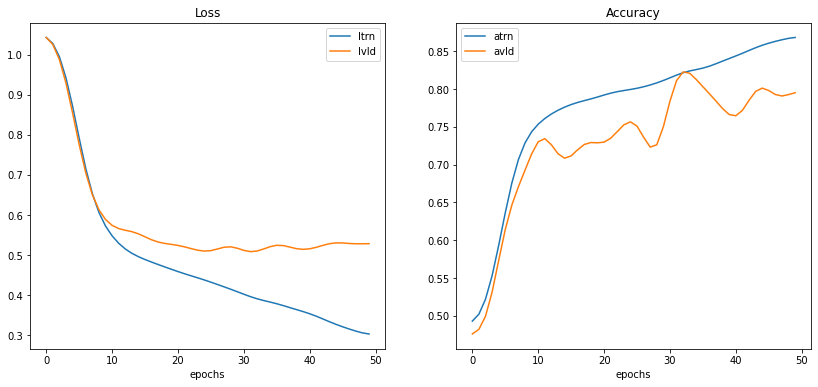

In [31]:
ltrn=gaussian_filter1d(Training_statsrec[0],sigma=2)
lvld=gaussian_filter1d(Training_statsrec[2],sigma=2)

x=[i for i in range(50)]
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title('Loss')
plt.xlabel('epochs')
plt.plot(x, ltrn,label='ltrn') 
plt.plot(x, lvld,label='lvld') 
plt.legend()

atrn=gaussian_filter1d(Training_statsrec[1],sigma=2)
avld=gaussian_filter1d(Training_statsrec[3],sigma=2)
plt.subplot(1,2,2)
plt.title('Accuracy')
plt.xlabel('epochs')
plt.plot(x, atrn,label='atrn')
plt.plot(x, avld,label='avld') 
plt.legend()
plt.show()

In [18]:
def get_all_pred(model,loader,categories_names):
    all_preds=torch.tensor([])
    all_targets=torch.tensor([])
    i=0
    with torch.no_grad():
        for batch in tqdm(loader):
            images,label=batch
            preds=model(images)
            
            all_preds=torch.cat((all_preds,preds),dim=0)
            all_targets=torch.cat((all_targets,label),dim=0)
            
        fig, ax = plt.subplots(figsize=(6,6))
        cm=confusion_matrix(all_targets.tolist(),all_preds.argmax(dim=1).tolist())
        conf_matrix=pd.DataFrame(data=cm,columns=categories_names
                                          ,index=categories_names)
        sns.heatmap(conf_matrix, annot=True, fmt="d",cmap='gray')
        
        plt.show()

In [19]:
categories_names=["BACTERIAL","NORMAL","VIRAL"]

100%|██████████| 58/58 [08:11<00:00,  8.48s/it]


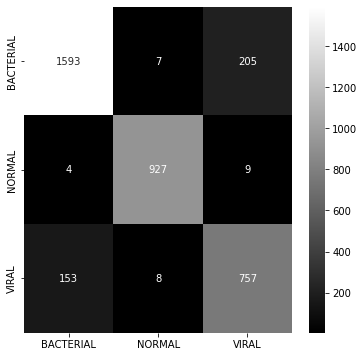

In [20]:
get_all_pred(model,train_loader,categories_names)

100%|██████████| 25/25 [03:31<00:00,  8.45s/it]


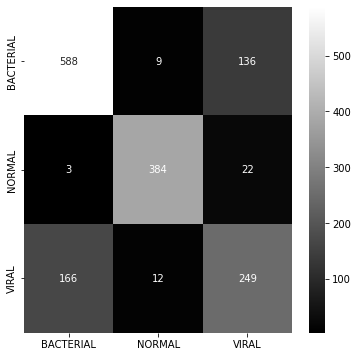

In [21]:
get_all_pred(model,valid_loader,categories_names)

In [22]:
class testSet(Dataset):
    def __init__(self,root,transform):
        self.root=root
        self.transform = transform
        self.data=[]
        self.namelabel={"BACTERIAL":0,"NORMAL":1,"VIRAL":2}


        for catagory in os.listdir(root):
            if catagory=='.DS_Store':
                continue
            catagory_path=os.path.join(root,catagory)
            for image in os.listdir(catagory_path):
                image_path=os.path.join(catagory_path,image)
                self.data.append((image_path,catagory))
        
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_loc = self.data[idx][0]
     
        # Use PIL for image loading
        image = Image.open(img_loc).convert("RGB")
        # Apply the transformations
        tensor_image = self.transform(image)
        label = torch.tensor(self.namelabel[self.data[idx][1]])
        return tensor_image, label

trnsfrm = transforms.Compose([
    transforms.Resize([224,224]),
    transforms.ToTensor(),
])

test_set=testSet(
    root='./chest_xray/chest_xray_ternary/test',
    transform=trnsfrm
)
test_loader=torch.utils.data.DataLoader(
    test_set,
    batch_size=64,
    num_workers=0
)

In [23]:
torch.save(model.state_dict(),'net.pth')
test_model=models.vgg16(pretrained=False)
test_model.classifier._modules['6'] = nn.Linear(4096,3)
test_model.load_state_dict(torch.load('net.pth'))

<All keys matched successfully>

100%|██████████| 10/10 [01:24<00:00,  8.43s/it]


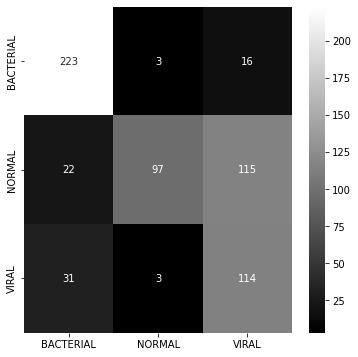

In [32]:
get_all_pred(test_model,test_loader,categories_names)

In [33]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1